In [78]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras. layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [79]:
 def read_text(deu_eng):
      file=open(deu_eng,mode='rt',encoding="utf-8")
      text=file.read()
      file.close()
      return text

In [80]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t')for i in sents]
    return sents

In [81]:
 data = read_text("/deu.txt")
 deu_eng = to_lines(data)
 deu_eng =array(deu_eng)

In [82]:
deu_eng = deu_eng[:50000,:]

In [83]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['We took a wrong turn.', 'Wir sind falsch abgebogen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #823901 (jellorage) & #2112094 (freddy1)'],
       ['We traveled together.', 'Wir waren zusammen auf Reisen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600396 (Pfirsichbaeumchen)'],
       ['We traveled together.', 'Wir sind zusammen gereist.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1582121 (Spamster) & #1600398 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [84]:
eng_1 = []
deu_1 = []

for i in deu_eng[:,0]:
    eng_1.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_1.append(len(i.split()))

In [85]:
length_df = pd.DataFrame({'eng':eng_1,'deu':deu_1})

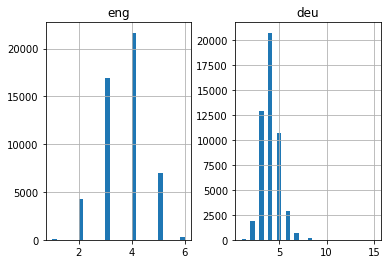

In [86]:
length_df.hist(bins = 30)
plt.show()

In [87]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [88]:
eng_tokenizer = tokenization(deu_eng[:,0])
eng_vocab_size = len(eng_tokenizer.word_index )+ 1

eng_length = 8
print('English Vocabulary Size: %d'% eng_vocab_size)

English Vocabulary Size: 6150


In [89]:
deu_tokenizer = tokenization(deu_eng[:,1])
deu_vocab_size = len(deu_tokenizer.word_index )+ 1

deu_length = 8
print('Deutch Vocabulary Size: %d'% deu_vocab_size)

Deutch Vocabulary Size: 10119


In [90]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [91]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state =12)

In [92]:
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [93]:
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [94]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [95]:

model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [75]:
filename = 'model.h1.22_Deepa'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1],1),
          epochs=5, batch_size=512,
          validation_split =0.2,
          callbacks=[checkpoint], verbose=1 )

Epoch 1/5
63/63 [==============================] - 261s 4s/step - loss: 4.3149 - val_loss: 2.9457

Epoch 00001: val_loss improved from inf to 2.94567, saving model to model.h1.22_Deepa


INFO:tensorflow:Assets written to: model.h1.22_Deepa/assets


INFO:tensorflow:Assets written to: model.h1.22_Deepa/assets


Epoch 2/5
63/63 [==============================] - 251s 4s/step - loss: 2.7446 - val_loss: 2.6877

Epoch 00002: val_loss improved from 2.94567 to 2.68767, saving model to model.h1.22_Deepa


INFO:tensorflow:Assets written to: model.h1.22_Deepa/assets


INFO:tensorflow:Assets written to: model.h1.22_Deepa/assets


Epoch 3/5
63/63 [==============================] - 251s 4s/step - loss: 2.5920 - val_loss: 2.5613

Epoch 00003: val_loss improved from 2.68767 to 2.56132, saving model to model.h1.22_Deepa


INFO:tensorflow:Assets written to: model.h1.22_Deepa/assets


INFO:tensorflow:Assets written to: model.h1.22_Deepa/assets


Epoch 4/5
63/63 [==============================] - 251s 4s/step - loss: 2.3909 - val_loss: 2.3613

Epoch 00004: val_loss improved from 2.56132 to 2.36129, saving model to model.h1.22_Deepa


INFO:tensorflow:Assets written to: model.h1.22_Deepa/assets


INFO:tensorflow:Assets written to: model.h1.22_Deepa/assets


Epoch 5/5
63/63 [==============================] - 251s 4s/step - loss: 2.2183 - val_loss: 2.2540

Epoch 00005: val_loss improved from 2.36129 to 2.25395, saving model to model.h1.22_Deepa


INFO:tensorflow:Assets written to: model.h1.22_Deepa/assets


INFO:tensorflow:Assets written to: model.h1.22_Deepa/assets


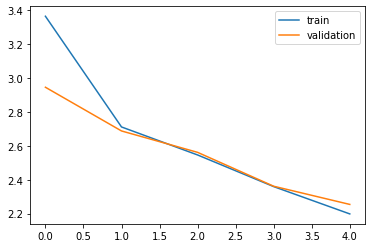

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

In [77]:
model = load_model('model.h1.22_Deepa')
preds = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [96]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [97]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)

        else:
            if (t==None):
                temp.append('')
            else:
                temp.append(t)

    preds_text.append(''.join(temp))

In [98]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})


In [99]:
pd.set_option('display.max_colwidth',200)

In [100]:
pred_df.head(15)

,actual,predicted
0,What is the number?,theyour
1,Try it on.,pleaseyou
2,We were wrong.,wehave
3,That's untrue.,ityou
4,Don't touch anything.,you're
5,Tom is calling back.,tomwas
6,I think Tom is awake.,ididn'ttom
7,What are you having?,howdoi
8,I like that flag.,ihaveto
9,You have a good job.,youa


In [101]:
pred_df.tail(15)

,actual,predicted
9985,I saw you looking.,iknowtom
9986,Tom was so busy.,tomhasa
9987,Where could he be?,hedidyou
9988,My friend was shot.,heyouris
9989,"Come on, trust me.",youto
9990,Life is too short.,it'sisa
9991,Everybody saw it.,you
9992,Try harder.,let'sme
9993,He will be punished.,hewasto
9994,I speak Swedish.,ilove
